# Surface Water Mass Transformation for Panan01

In [1]:
import intake
import cosima_cookbook as cc

import cartopy.crs as ccrs
import cf_xarray as cfxr
import cmocean as cm
import dask.distributed as dsk
import gsw
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.colors as mcolors
import numpy as np
import xarray as xr

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)

### Computing surface water mass transformation

We will do this by defining three functions. The first one loads the diagnostics needed (independently of the model). The second one actually calculates the transformations, and a third one does the density binning.

In [3]:
def get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom5'):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom5": {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_net"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    },
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if k in ["area", "maximum_depth"]:
                ds[k][var] = cc.querying.getvar(expt, var, session, n = 1) 
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice)
            else:
                ds[k][var] = cc.querying.getvar(expt, var, session,
                                                frequency = freq,
                                                start_time = start_time,
                                                end_time = end_time,
                                                chunks = {'time': 'auto'})
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice, time = slice(start_time, end_time))
                
                # Correct temperatures (if in K convert to C)
                if k == 'temperature' and np.max(ds[k][var]) > 100:
                    ds[k][var] = ds[k][var] - 273.15

                # If 3D field, grab the surface
                if ds[k][var].cf.axes.get('Z'):
                    surface_z = ds[k][var].cf['Z'][0].values
                    ds[k][var] = ds[k][var].cf.sel(Z = 0, method = 'nearest')

    # Get temperature and salinity to calculate a couple other things we'll need later on
    CT = ds['temperature'][model_vars[model]['temperature'][0]]
    SP = ds['salinity'][model_vars[model]['salinity'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.cf['Y']).rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.cf['X'], SP.cf['Y']).rename('SA')

    # Calculate potential density
    pot_rho_1 = gsw.sigma1(SA, CT).rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_1'] = pot_rho_1
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

Defining the salt and heat transformations

In [4]:
def compute_salt_transformation(ds):
    
    # First retrieve temperature and water_flux as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Multiply the water flux by absolute salinity to get it in the correct units
    water_flux_into_ocean = xr.Dataset(ds['water_flux_into_ocean']).to_array().squeeze().drop_vars('variable')
    water_flux_into_ocean = ds['SA'] * water_flux_into_ocean

    # Caculate the haline contraction coefficient
    haline_contraction = gsw.beta(ds['SA'], CT, ds['pressure']).rename('beta')

    # Calculate the net salt flux and multiply by 1000 to convert units
    net_salt_flux = xr.Dataset(ds['salt_flux']).to_array().sum(dim = 'variable') * 1000

    # Note that we also multiply pme_net by absolute salinity to have the correct units
    salt_transformation = haline_contraction * (water_flux_into_ocean - net_salt_flux) * ds['days_per_month']
    salt_transformation = salt_transformation.load()

    return salt_transformation

def compute_heat_transformation(ds):

    # First retrieve temperature as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Calculate the thermal expansion coefficient 
    thermal_expansion = gsw.alpha(ds['SA'], CT, ds['pressure']).rename('alpha')
    
    # Calculate the net surface heating
    net_surface_heating = xr.Dataset(ds['heat_flux']).to_array().sum(dim = 'variable')
    
    # Calculate the heat transformation
    heat_transformation = thermal_expansion * net_surface_heating * ds['days_per_month']
    heat_transformation = heat_transformation.load()

    return heat_transformation


Now we need to do the isopycnal re-binning

In [5]:
def isopycnal_bins(ds, salt_transformation, heat_transformation):
    
    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_1 
    # was within the bin, there it has a time summed transformation value.
    
    isopycnal_bins = np.arange(31, 33.5, 0.02) #e.g. first bin going from 31.00 to 31.02
    bin_bottoms = isopycnal_bins[:-1]    
    pot_rho_1 = ds['pot_rho_1']
    X = pot_rho_1.cf['longitude']
    Y = pot_rho_1.cf['latitude']
    
    binned_salt_transformation = xr.DataArray(np.zeros([len(bin_bottoms), len(Y), len(X)]), 
                                              coords = [bin_bottoms, Y, X], 
                                              dims = ['isopycnal_bins', Y.name, X.name], 
                                              name = 'salt_transformation')

    binned_heat_transformation = xr.DataArray(np.zeros([len(bin_bottoms), len(Y), len(X)]), 
                                              coords = [bin_bottoms, Y, X], 
                                              dims = ['isopycnal_bins', Y.name, X.name], 
                                              name = 'temp_transformation')
    
    binned_salt_transformation = binned_salt_transformation.chunk({'isopycnal_bins': 1})
    binned_heat_transformation = binned_heat_transformation.chunk({'isopycnal_bins': 1})
    
    for i in range(len(isopycnal_bins)-1):
        bin_mask = pot_rho_1.where(pot_rho_1 <= isopycnal_bins[i+1]).where(pot_rho_1 > isopycnal_bins[i]) * 0 + 1
        masked_transform = (salt_transformation * bin_mask).sum('time')
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_salt_transformation[i, :, :] = masked_transform

        masked_transform = (heat_transformation * bin_mask).sum('time')
        masked_transform = masked_transform.where(masked_transform != 0) 
        masked_transform = masked_transform.load()
        binned_heat_transformation[i, :, :] = masked_transform

    ndays = ds['days_per_month'].sum().values
    salt_transformation = binned_salt_transformation / ndays
    
    c_p = 3992.1 # J kg-1 degC-1
    heat_transformation = binned_heat_transformation / c_p / ndays

    isopycnal_bin_diff = np.diff(isopycnal_bins)
    salt_transformation = salt_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation = heat_transformation / isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    
    isopycnal_bin_mid = (isopycnal_bins[1:] + isopycnal_bins[:-1]) / 2
    salt_transformation['isopycnal_bins'] = isopycnal_bin_mid
    heat_transformation['isopycnal_bins'] = isopycnal_bin_mid
    
    # Change the sign so that positive means conversion into denser water masses
    salt_transformation = -1 * salt_transformation
    heat_transformation = -1 * heat_transformation

    return salt_transformation, heat_transformation

## Using Panan01

In [6]:
# Change to your experiment of interest
expt = 'panant-01-zstar-ACCESSyr2'
db = '/home/272/kc5856/databases/honours_test.db'
session = cc.database.create_session(db)
freq = '1 monthly'

# Select time period and region
start_time = '2008-01-01'
end_time = '2010-12-31'
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

In [7]:
ds = get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice, model = "mom6")

In [8]:
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

In [ ]:
#ALREADY RUN, shouldn't need to re run. 

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/binned_salt_transformation_short_mom6.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/binned_heat_transformation_short_mom6.nc')

In [7]:
salt_tr = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/binned_salt_transformation_mom6.nc', chunks = {'isopycnal_bins': 1})
heat_tr = xr.open_dataarray('/g/data/g40/kc5856/access_panan_ssp126_SWMT/binned_heat_transformation_mom6.nc', chunks = {'isopycnal_bins': 1})
net_tr = salt_tr + heat_tr

Doing the same for the perturbation experiment:

In [8]:
## For perturbation

expt = 'panant-01-zstar-ssp126-MW-only'
freq = '1 monthly'

# Select period and region
start_time = '2007-01-01'
end_time = '2010-12-31'
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

In [12]:
ds = get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice, model = "mom6")

In [12]:
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

In [13]:
salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('binned_salt_transformation_melt_pan01_mom6.nc')
heat_transformation_binned.to_netcdf('binned_heat_transformation_melt_pan01_mom6.nc')

2025-04-11 15:23:08,033 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name='gather_dep(tcp://127.0.0.1:34689, {...})' coro=<Worker.gather_dep() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2025-04-11 15:23:08,033 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name='gather_dep(tcp://127.0.0.1:34689, {...})' coro=<Worker.gather_dep() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/worker_state_machine.py:3615>> ended with CancelledError
2025-04-11 15:23:08,034 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name='gather_dep(tcp://127.0.0.1:34689, {...})' coro=<Worker.gather_dep() done, defined at /g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distrib

KeyboardInterrupt: 

In [9]:
salt_tr_melt = xr.open_dataarray('binned_salt_transformation_melt_pan01_mom6.nc', chunks = {'isopycnal_bins': 1})
heat_tr_melt = xr.open_dataarray('binned_heat_transformation_melt_pan01_mom6.nc', chunks = {'isopycnal_bins': 1})
net_tr_melt = salt_tr_melt + heat_tr_melt

In [10]:
#Defining the data separately for when we are not needing it in the functions

ds_cont = get_variables('panant-01-zstar-ACCESSyr2', freq, start_time, end_time, lon_slice, lat_slice, model = "mom6")
ds_melt = get_variables('panant-01-zstar-ssp126-MW-only', freq, start_time, end_time, lon_slice, lat_slice, model = "mom6")


### Antarctic shelf dense water formation

In [11]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [12]:
depth = xr.Dataset(ds_cont['maximum_depth']).to_array().squeeze()
depth_melt = xr.Dataset(ds_melt['maximum_depth']).to_array().squeeze()
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6')

In [13]:
area = xr.Dataset(ds_cont['area']).to_array().squeeze().drop_vars('variable')

swmt_shelf = (net_tr * area / 1e6).where(shelf_mask == 1)
heat_shelf = (heat_tr * area / 1e6).where(shelf_mask == 1)
salt_shelf = (salt_tr * area / 1e6).where(shelf_mask == 1)
swmt_shelf_sum = swmt_shelf.cf.sum(['longitude', 'latitude'])
heat_shelf_sum = heat_shelf.cf.sum(['longitude', 'latitude'])
salt_shelf_sum = salt_shelf.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_sum, heat_shelf_sum, salt_shelf_sum]:
    da.attrs["units"] = "Sv"

In [14]:
area_melt = xr.Dataset(ds_melt['area']).to_array().squeeze().drop_vars('variable')

swmt_shelf_melt = (net_tr_melt * area_melt / 1e6).where(shelf_mask == 1)
heat_shelf_melt = (heat_tr_melt * area_melt / 1e6).where(shelf_mask == 1)
salt_shelf_melt = (salt_tr_melt * area_melt / 1e6).where(shelf_mask == 1)
swmt_shelf_melt_sum = swmt_shelf_melt.cf.sum(['longitude', 'latitude'])
heat_shelf_melt_sum = heat_shelf_melt.cf.sum(['longitude', 'latitude'])
salt_shelf_melt_sum = salt_shelf_melt.cf.sum(['longitude', 'latitude'])

for da in [swmt_shelf_melt_sum, heat_shelf_melt_sum, salt_shelf_melt_sum]:
    da.attrs["units"] = "Sv"

In [15]:
transformation_density = 32.52
shelf_subduction_plot = net_tr.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt = depth.cf['X']
swmt_yt = depth.cf['Y']

In [16]:
transformation_density = 32.52
shelf_subduction_plot_melt = net_tr_melt.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt_melt = depth_melt.cf['X']
swmt_yt_melt = depth_melt.cf['Y']

In [17]:
anom_xt = swmt_xt_melt - swmt_xt
anom_yt = swmt_yt_melt - swmt_yt

In [18]:
shelf_subduction_plot_anom = shelf_subduction_plot_melt - shelf_subduction_plot

In [57]:
import matplotlib.path as mpath

In [105]:
cont_d25 = 32.7175
cont_d75 = 32.5125
melt_d25 = 32.7075
melt_d75 = 32.5225

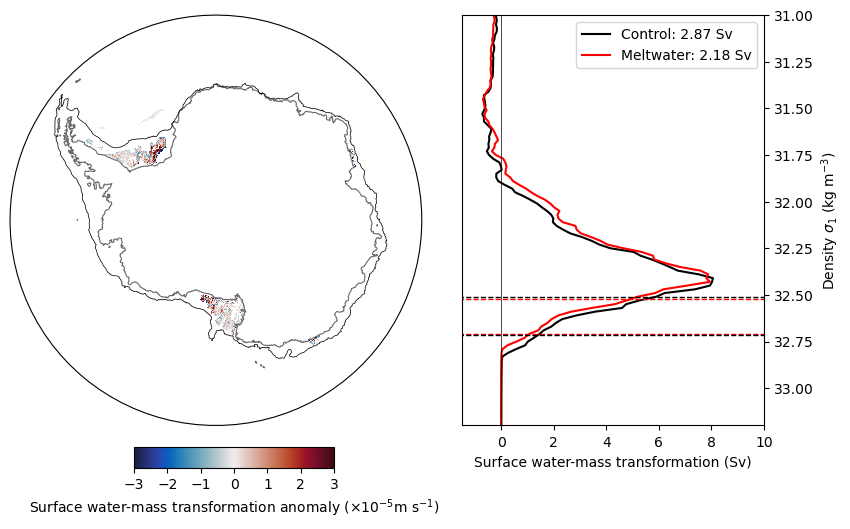

In [115]:
fig = plt.figure(1, figsize = (10, 5.33))
gs = gridspec.GridSpec(1, 2, width_ratios = [3, 2], wspace = 0.05)

ax, ax1 = plt.subplot(gs[0], projection = ccrs.SouthPolarStereo()), plt.subplot(gs[1])
ax.set_extent([-180, 180, -90, -59], ccrs.PlateCarree())

theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

ax.contour(land_mask.cf['X'], land_mask.cf['Y'], land_mask,
           levels = [0, 1], colors = 'dimgrey', linewidths=0.75, transform = ccrs.PlateCarree())
ax.contour(shelf_mask.cf['X'], shelf_mask.cf['Y'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5, transform = ccrs.PlateCarree())

norm = mcolors.Normalize(vmin = -2.5, vmax = 2.5)
plot_swmt = ax.pcolormesh(swmt_xt, swmt_yt, shelf_subduction_plot_anom,
                          vmin = -3, vmax = 3,
                          cmap = cm.cm.balance,
                          transform = ccrs.PlateCarree())

cax = fig.add_axes([0.27, 0.03, 0.2, 0.04])
cbar = plt.colorbar(plot_swmt, cax=cax, orientation='horizontal', shrink = 0.5, ticks = [-3,-2,-1,0, 1, 2, 3])
cbar.set_label(r'Surface water-mass transformation anomaly ($\times 10^{-5}$m s$^{-1}$)')

ax1.plot(swmt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'k', label='Control: 2.87 Sv')
ax1.plot(swmt_shelf_melt_sum, swmt_shelf_melt_sum['isopycnal_bins'], color = 'r', label='Meltwater: 2.18 Sv')
#ax1.plot(heat_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'r', label='heat')
#ax1.plot(salt_shelf_sum, swmt_shelf_sum['isopycnal_bins'], color = 'b', label='salt')
ax1.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15], [melt_d25, melt_d25], 'r--', linewidth=1)
ax1.plot([-5, 15], [melt_d75, melt_d75], 'r--', linewidth=1)
ax1.plot([-5, 15], [cont_d25, cont_d25], 'k--', linewidth=1)
ax1.plot([-5, 15], [cont_d75, cont_d75], 'k--', linewidth=1)
#ax1.plot([-5, 15], [transformation_density, transformation_density], 'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel('Density $\sigma_1$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')
ax1.legend();

Control max = 32.41 kg/m^3 => 2.8671181 Sv.
    control zero = 32.82
    0.41 diff.
    25% of max = 32.7175
    75% of max =  32.5125
    
Melt max = 32.43 kg/m^3 => 2.17811335 Sv.
    melt zero = 32.80
    0.37 diff.
    25% of max = 32.7075
    75% of max = 32.5225

#### Integrate over 25-75% for mean

In [91]:
ans_con = (32.51+32.53+32.55+32.57+32.59+32.61+32.63+32.65+32.67+32.69+32.71)/11
ans_melt=(32.51+32.53+32.55+32.57+32.59+32.61+32.63+32.65+32.67+32.69)/10
print('control average = ',ans_con, ', melt average =', ans_melt)

control average =  32.61 , melt average = 32.6


In [109]:
swmt_shelf_melt_sum

<xarray.DataArray (isopycnal_bins: 124)> Size: 992B
dask.array<sum-aggregate, shape=(124,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 992B 31.01 31.03 ... 33.45 33.47
Attributes:
    units:    Sv

In [111]:
#SWMT for control
c0 = swmt_shelf_melt_sum.sel(isopycnal_bins='32.45',method='nearest').compute()
c1 = swmt_shelf_melt_sum.sel(isopycnal_bins='32.43',method='nearest').compute()
c2 = swmt_shelf_melt_sum.sel(isopycnal_bins='32.41',method='nearest').compute()
c3 = swmt_shelf_melt_sum.sel(isopycnal_bins='32.39',method='nearest').compute()
c4 = swmt_shelf_melt_sum.sel(isopycnal_bins='32.37',method='nearest').compute()
print(c0, c1,c2,c3,c4)

<xarray.DataArray ()> Size: 8B
array(7.07811888)
Coordinates:
    isopycnal_bins  float64 8B 32.45
Attributes:
    units:    Sv <xarray.DataArray ()> Size: 8B
array(7.93580993)
Coordinates:
    isopycnal_bins  float64 8B 32.43
Attributes:
    units:    Sv <xarray.DataArray ()> Size: 8B
array(7.80256263)
Coordinates:
    isopycnal_bins  float64 8B 32.41
Attributes:
    units:    Sv <xarray.DataArray ()> Size: 8B
array(7.87485312)
Coordinates:
    isopycnal_bins  float64 8B 32.39
Attributes:
    units:    Sv <xarray.DataArray ()> Size: 8B
array(7.58400503)
Coordinates:
    isopycnal_bins  float64 8B 32.37
Attributes:
    units:    Sv


In [102]:
#SWMT for control

<xarray.DataArray ()> Size: 8B
array(2.8671181)
Coordinates:
    isopycnal_bins  float64 8B 32.61
Attributes:
    units:    Sv


In [112]:
a1 = swmt_shelf_sum.sel(isopycnal_bins='32.61',method='nearest').compute()
b1 = swmt_shelf_melt_sum.sel(isopycnal_bins='32.60',method='nearest').compute()
print('control = ',a1,', meltwater = ',b1)

control =  <xarray.DataArray ()> Size: 8B
array(2.8671181)
Coordinates:
    isopycnal_bins  float64 8B 32.61
Attributes:
    units:    Sv , meltwater =  <xarray.DataArray ()> Size: 8B
array(2.17811335)
Coordinates:
    isopycnal_bins  float64 8B 32.61
Attributes:
    units:    Sv


### Plotting

In [27]:
area = xr.Dataset(ds_cont['area']).to_array().squeeze().drop_vars('variable')

swmt = (area * net_tr / 1e6).cf.sum(['longitude', 'latitude'])
swmt_heat = (area * heat_tr / 1e6).cf.sum(['longitude', 'latitude'])
swmt_salt = (area * salt_tr / 1e6).cf.sum(['longitude', 'latitude'])

for da in [swmt, swmt_heat, swmt_salt]:
    da.attrs["units"] = "Sv"

In [28]:
area_melt = xr.Dataset(ds_melt['area']).to_array().squeeze().drop_vars('variable')

swmt_melt = (area_melt * net_tr_melt / 1e6).cf.sum(['longitude', 'latitude'])
swmt_heat_melt = (area_melt * heat_tr_melt / 1e6).cf.sum(['longitude', 'latitude'])
swmt_salt_melt = (area_melt * salt_tr_melt / 1e6).cf.sum(['longitude', 'latitude'])

for da in [swmt_melt, swmt_heat_melt, swmt_salt_melt]:
    da.attrs["units"] = "Sv"

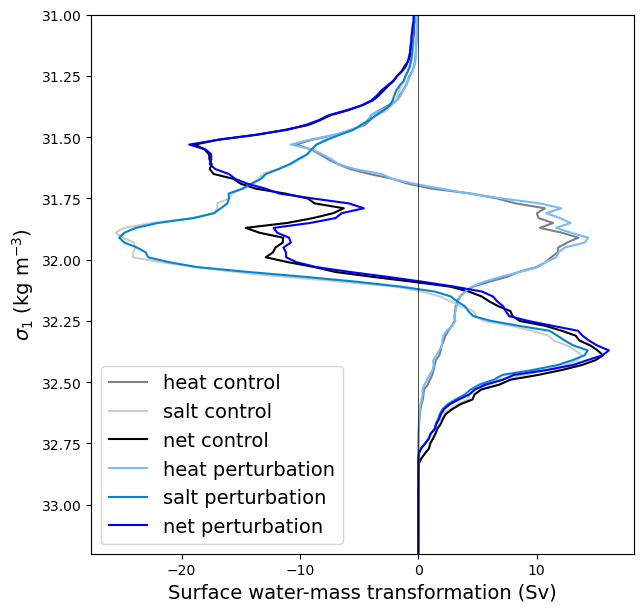

In [36]:
figure = plt.figure(figsize = (7, 7))



plt.plot(swmt_heat, swmt['isopycnal_bins'], color = '0.5', label='heat control')
plt.plot(swmt_salt, swmt['isopycnal_bins'], color = '0.8', label='salt control')
plt.plot(swmt, swmt['isopycnal_bins'], color = 'k', label='net control')
plt.plot(swmt_heat_melt, swmt['isopycnal_bins'], color = 'xkcd:sky blue', label='heat perturbation')
plt.plot(swmt_salt_melt, swmt['isopycnal_bins'], color = 'xkcd:cerulean', label='salt perturbation')
plt.plot(swmt_melt, swmt_melt['isopycnal_bins'], color = 'b', label='net perturbation')
plt.plot([0, 0], [31, 33.2], 'k', linewidth = 0.5)
plt.ylim((33.2, 31))
plt.ylabel(r'$\sigma_1$ (kg m$^{-3}$)', fontsize = 14)
plt.xlabel('Surface water-mass transformation (Sv)', fontsize = 14)
plt.legend(loc = 3, fontsize = 14);